# boltzmann_machine을 활용하여 Fashion MNIST generation 실험

In [164]:
import torch
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.autograd import Variable

In [165]:
def load_dataset(batch_size=64, is_train=True):
    # For Debugging
    torch.manual_seed(42)
    _data_set = datasets.FashionMNIST(
        root      = './dataset',
        train     = True,
        download  = True,
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])
    )

    _data_loader = DataLoader(
        dataset     = _data_set,
        batch_size  = batch_size,
        shuffle     = True,
        num_workers = 2
    )

    return _data_loader

data_loader = load_dataset()

## 모델 정의

In [212]:
class RBM(nn.Module):
    def __init__(self,
                 n_vis=784,
                 n_hin=500,
                 k=5):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k

    def sample_from_p(self,p):
        return F.relu(torch.sign(p - p.clone().uniform_()))

    def v_to_h(self,v):
        p_h = F.sigmoid(F.linear(v,self.W,self.h_bias))
        sample_h = self.sample_from_p(p_h)
        return p_h,sample_h

    def h_to_v(self,h):
        p_v = F.sigmoid(F.linear(h,self.W.t(),self.v_bias))
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v

    def forward(self,v):
        pre_h1,h1 = self.v_to_h(v)

        h_ = h1
        for _ in range(self.k):
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)

        return v,v_

    def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v,self.W,self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()

## 모델 학습

In [208]:
import torch.optim as optim
import torch.nn as nn
import time
import copy

In [209]:
def AddGaussianNoise(tensor, std=0.1, mean=0):
    return tensor + torch.randn(tensor.size()) * std + mean

In [210]:
NUM_OF_EPOCH = 20

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = RBM(k=5)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.005) # 기울기 업데이트 -> how to?
criterion = nn.MSELoss()# y_hat과 y의 차이를 구함

best_model_weights = copy.deepcopy(model.state_dict())
best_loss = float("inf")

In [211]:
for epoch in range(NUM_OF_EPOCH):
    model.train()

    running_loss = 0.0

    for _inputs, _ in data_loader:
        inputs = _inputs.view(-1, 28*28).to(device)
        sample_inputs = inputs.bernoulli()
        optimizer.zero_grad() # 이전에 구했던 기울기를 0으로 초기화 함

        v, v1 = model(inputs) # 네트워크를 통과시킴 => computational graph가 만들어짐
        loss = model.free_energy(v) - model.free_energy(v1)

        # back-propagation
        loss.backward()
        optimizer.step()

        running_loss += float(loss.item() * inputs.size(0))

    epoch_loss = running_loss / len(data_loader.dataset)

    print('Epoch {}/{}: {} Loss: {:.4f}'.format(epoch + 1, NUM_OF_EPOCH,"train", epoch_loss))

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_model_weights = copy.deepcopy(model.state_dict())

Epoch 1/20: train Loss: -3.0894
Epoch 2/20: train Loss: 4.0526
Epoch 3/20: train Loss: 4.2523
Epoch 4/20: train Loss: 3.8173
Epoch 5/20: train Loss: 3.6194
Epoch 6/20: train Loss: 3.6231
Epoch 7/20: train Loss: 3.6118
Epoch 8/20: train Loss: 3.6338
Epoch 9/20: train Loss: 3.5848
Epoch 10/20: train Loss: 3.6662
Epoch 11/20: train Loss: 3.7042
Epoch 12/20: train Loss: 3.7779
Epoch 13/20: train Loss: 3.7854
Epoch 14/20: train Loss: 3.8718
Epoch 15/20: train Loss: 3.9204
Epoch 16/20: train Loss: 3.9545
Epoch 17/20: train Loss: 4.0012
Epoch 18/20: train Loss: 4.0017
Epoch 19/20: train Loss: 4.0413
Epoch 20/20: train Loss: 4.0410


In [213]:
# save model weight
torch.save(best_model_weights, './weights/best_weights.pth')

### 학습이 잘 되었는지 시각화

In [214]:
import matplotlib.pyplot as plt

In [215]:
weight_path = './weights/best_weights.pth'

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 모델 구성후 학습된 파라미터 로드
model = RBM(k=5)
model.load_state_dict(torch.load(weight_path))
model.to(device)

RBM()

In [216]:
# testing
with torch.no_grad():
    model.eval()
    test_data = data_loader.dataset[1][0].view(-1, 28*28).to(device)
    origin, generate = model(test_data)

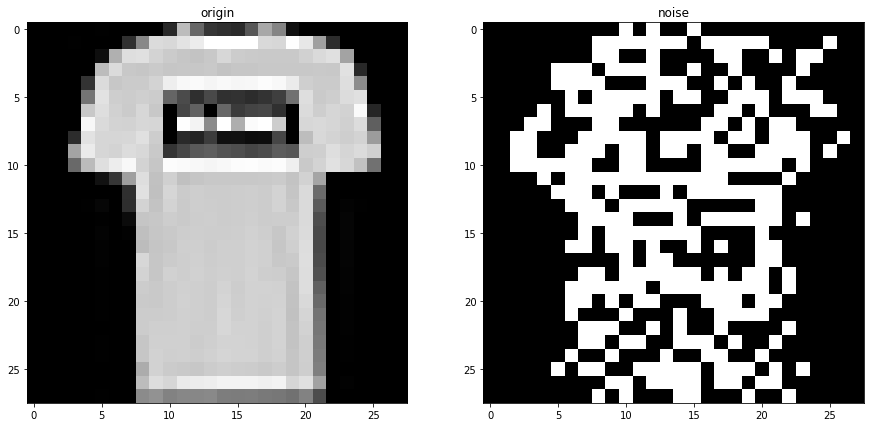

In [217]:
# 시각화
test_data = origin.view(28,28).to("cpu")
test_generate = generate.view(28,28).to("cpu")

f, a = plt.subplots(1, 2, figsize=(15, 15))
a[0].set_title('origin')
a[1].set_title('noise')

a[0].imshow(test_data, cmap='gray')
a[1].imshow(test_generate, cmap='gray')